In [1]:
# Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sn

import quandl
from config1 import quandl_api_key

from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.stats import linregress
from scipy.stats import zscore
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# API Calls to Quandl

# Treasury Yield Curve
try:
    treas_ylds = quandl.get("USTREASURY/YIELD", authtoken=quandl_api_key)
    treas_ylds.to_csv("quandl_data/treas_yld_curve.csv")
    print("Successfully downloaded and exported Treasury Yield Curve data")
    
except Exception as e:
    print(e)
    
# S&P 500 Monthly Dividend Yield
try:   
    sp500_div_yld = quandl.get("MULTPL/SP500_DIV_YIELD_MONTH", authtoken=quandl_api_key)
    sp500_div_yld.to_csv("quandl_data/sp500_div_yld.csv")
    print("Successfully downloaded and exported S&P 500 Monthly Dividend Yield data")
    
except Exception as e:
    print(e)   
    
# S&P 500 2-Month Futures
try:  
    sp500_1m = quandl.get("CHRIS/CME_ES2", authtoken=quandl_api_key) 
    sp500_1m.to_csv("quandl_data/sp500_2m.csv")
    print("Successfully downloaded and exported S&P 500 2-Month Futures data")

except Exception as e:
    print(e)
    
# TED Spread (3-Month LIBOR - 3-Month Treasury)
try:  
    ted_spread = quandl.get("FRED/TEDRATE", authtoken=quandl_api_key) 
    ted_spread.to_csv("quandl_data/ted_spread.csv")
    print("Successfully downloaded and exported TED Spread (3-Month LIBOR - 3-Month Treasury) data")

except Exception as e:
    print(e)

Successfully downloaded and exported Treasury Yield Curve data
Successfully downloaded and exported S&P 500 Monthly Dividend Yield data
Successfully downloaded and exported S&P 500 2-Month Futures data
Successfully downloaded and exported TED Spread (3-Month LIBOR - 3-Month Treasury) data


In [3]:
def df_datefilter(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df["Date"] >= begin_date) & (original_df["Date"] <= end_date)]

    return sort_dates_df

In [4]:
raw_sp500_df = sp500_1m[["Settle", "Open", "High", "Low", "Last"]].join(sp500_div_yld, how="outer").rename(columns={"Settle": "SP500", "Value": "Div Yld"})
raw_sp500_df

,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1871-01-31,NaN,NaN,NaN,NaN,NaN,5.86
1871-02-28,NaN,NaN,NaN,NaN,NaN,5.78
1871-03-31,NaN,NaN,NaN,NaN,NaN,5.64
1871-04-30,NaN,NaN,NaN,NaN,NaN,5.49
1871-05-31,NaN,NaN,NaN,NaN,NaN,5.35
...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,NaN
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,NaN
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,NaN


In [5]:
filtered_sp500_df = raw_sp500_df[raw_sp500_df["SP500"].notna()].copy()
filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "1990-01-30")]
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,NaN
...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,NaN
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,NaN
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,NaN


In [6]:
#Calculate Daily Dividend Yield from the monthly value

div_yield_list = []
dollar_yield_list = []

dollar_yield = 0

for index, row in filtered_sp500_df.iterrows():
    price_row = row["SP500"]
    yield_row = row["Div Yld"]
    if yield_row > 0:
        div_yield_list.append(round(yield_row, 2))
        current_yield = yield_row
        dollar_yield = (current_yield / 100) * price_row
        dollar_yield_list.append(round(dollar_yield, 2))
    else:
        percent_yield = dollar_yield / price_row *100
        div_yield_list.append(round(percent_yield, 2))
    
print(len(div_yield_list))   

filtered_sp500_df["Div Yld"] = div_yield_list

filtered_sp500_df

5813


,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00
...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,1.89
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89


In [7]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [8]:
filtered_sp500_df["RSI"] = computeRSI(filtered_sp500_df["Last"], 14)
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI
Date,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN
...,...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,1.89,56.360249
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.854573
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,56.187385


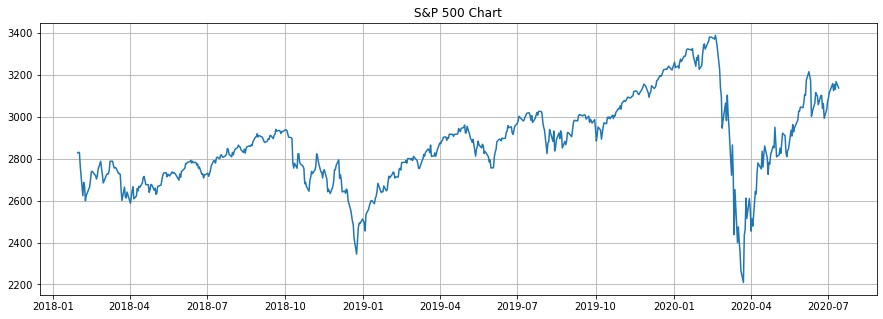

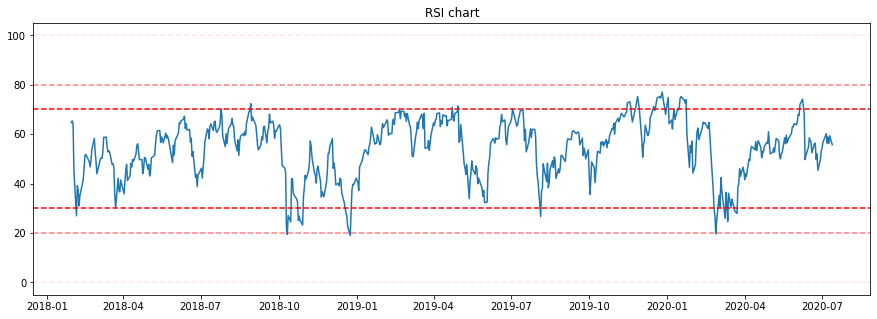

In [9]:
copy_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2018-01-30")].copy()
copy_filtered_sp500_df = copy_filtered_sp500_df.reset_index()

# plot price
plt.figure(figsize=(15,5))
plt.plot(copy_filtered_sp500_df['Date'], copy_filtered_sp500_df['Last'])
plt.title('S&P 500 Chart')
plt.grid(alpha=1)
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(copy_filtered_sp500_df['Date'], copy_filtered_sp500_df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1, color="red")
plt.axhline(20, linestyle='--', alpha=0.5, color="red")
plt.axhline(30, linestyle='--', color="red")

plt.axhline(70, linestyle='--', color="red")
plt.axhline(80, linestyle='--', alpha=0.5, color="red")
plt.axhline(100, linestyle='--', alpha=0.1, color="red")
plt.show()

In [10]:
filtered_sp500_df["50-DaySMA"] = filtered_sp500_df["Last"].rolling(window=50).mean()
filtered_sp500_df["100-DaySMA"] = filtered_sp500_df["Last"].rolling(window=100).mean()
filtered_sp500_df["200-DaySMA"] = filtered_sp500_df["Last"].rolling(window=200).mean()
#filtered_sp500_df["Expo20-DayMA"] = filtered_sp500_df["Last"].ewm(halflife=0.5, min_periods=20).mean()
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,50-DaySMA,100-DaySMA,200-DaySMA
Date,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,1.89,56.360249,3001.810,2897.0975,3017.67500
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.854573,3007.710,2894.8525,3018.50125
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,56.187385,3013.295,2892.3575,3019.14375


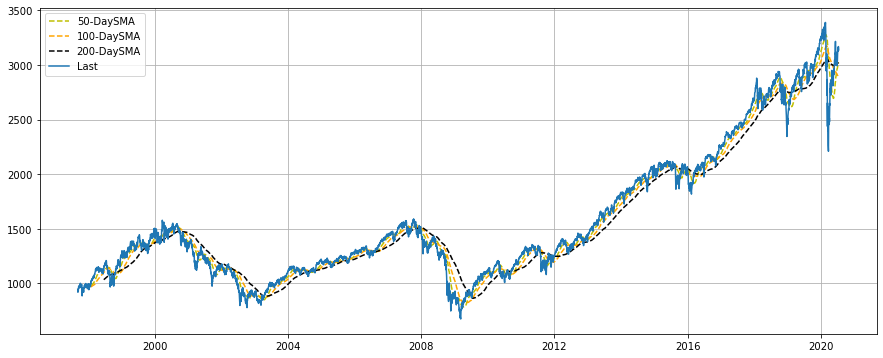

In [11]:
copysma_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "1990-01-30")].copy()
copysma_filtered_sp500_df = copysma_filtered_sp500_df#.reset_index()

plt.figure(figsize=(15,6))
plt.plot(copysma_filtered_sp500_df['50-DaySMA'], 'y--', label="50-DaySMA")
plt.plot(copysma_filtered_sp500_df['100-DaySMA'], '--', label="100-DaySMA", color="orange")
plt.plot(copysma_filtered_sp500_df['200-DaySMA'], 'k--', label="200-DaySMA")
#plt.plot(copysma_filtered_sp500_df['Expo20-DayMA'], 'g--', label="Expo20-DayMA")
plt.plot(copysma_filtered_sp500_df["Last"], label="Last")
plt.grid(alpha=1)
plt.legend()
plt.show()

In [12]:
filtered_sp500_df['3Std_Upper'] = filtered_sp500_df["Last"].rolling(window=20).mean() + filtered_sp500_df["Last"].rolling(window=20).std()*3
filtered_sp500_df['2Std_Upper'] = filtered_sp500_df["Last"].rolling(window=20).mean() + filtered_sp500_df["Last"].rolling(window=20).std()*2
filtered_sp500_df['Middle_Band'] = filtered_sp500_df["Last"].rolling(window=20).mean()
filtered_sp500_df['2Std_Lower'] = filtered_sp500_df["Last"].rolling(window=20).mean() - filtered_sp500_df["Last"].rolling(window=20).std()*2
filtered_sp500_df['3Std_Lower'] = filtered_sp500_df["Last"].rolling(window=20).mean() - filtered_sp500_df["Last"].rolling(window=20).std()*3
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,50-DaySMA,100-DaySMA,200-DaySMA,3Std_Upper,2Std_Upper,Middle_Band,2Std_Lower,3Std_Lower
Date,,,,,,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,1.89,56.360249,3001.810,2897.0975,3017.67500,3248.388710,3194.588306,3086.9875,2979.386694,2925.586290
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.854573,3007.710,2894.8525,3018.50125,3235.640056,3185.422537,3084.9875,2984.552463,2934.334944
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,56.187385,3013.295,2892.3575,3019.14375,3224.249455,3177.132970,3082.9000,2988.667030,2941.550545


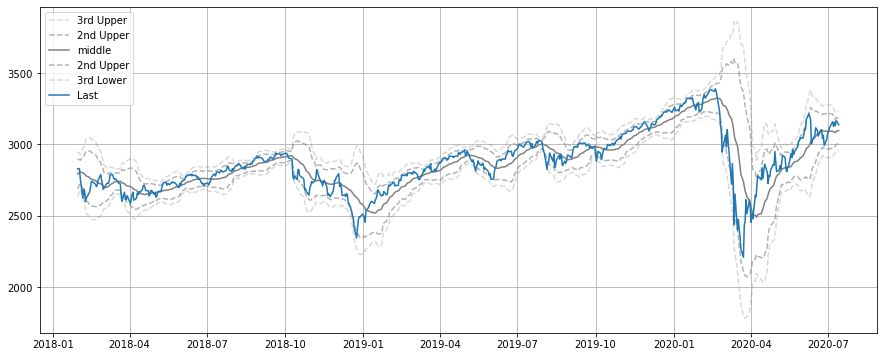

In [13]:
copyBB_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2018-01-30")].copy()
copyBB_filtered_sp500_df = copyBB_filtered_sp500_df#.reset_index()

plt.figure(figsize=(15,6))
plt.plot(copyBB_filtered_sp500_df['3Std_Upper'], '--', label="3rd Upper", color="grey", alpha=0.3)
plt.plot(copyBB_filtered_sp500_df['2Std_Upper'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(copyBB_filtered_sp500_df['Middle_Band'], '-', label="middle", color="grey")
plt.plot(copyBB_filtered_sp500_df['2Std_Lower'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(copyBB_filtered_sp500_df['3Std_Lower'], '--', label="3rd Lower", color="grey", alpha=0.3)
plt.plot(copyBB_filtered_sp500_df["Last"], label="Last")
plt.grid(alpha=1)
plt.legend()
plt.show()

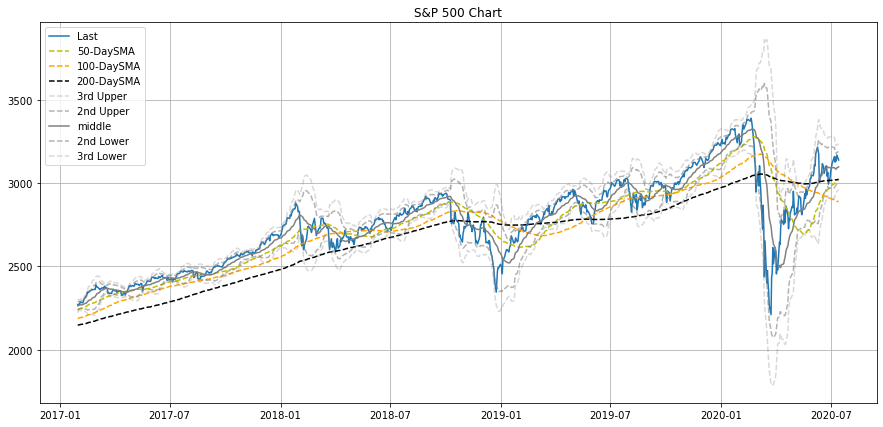

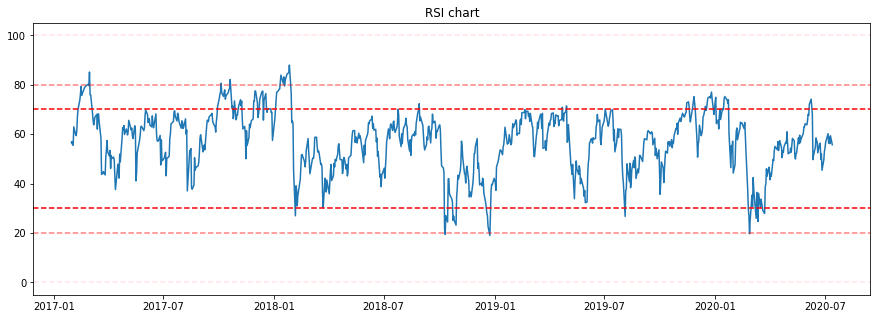

In [14]:
all_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2017-01-30")].copy()
all_filtered_sp500_df = all_filtered_sp500_df#.reset_index()

# plot price
plt.figure(figsize=(15,7))
plt.plot(all_filtered_sp500_df['Last'], label="Last")
plt.plot(all_filtered_sp500_df['50-DaySMA'], 'y--', label="50-DaySMA")
plt.plot(all_filtered_sp500_df['100-DaySMA'], '--', label="100-DaySMA", color="orange")
plt.plot(all_filtered_sp500_df['200-DaySMA'], 'k--', label="200-DaySMA")
plt.plot(all_filtered_sp500_df['3Std_Upper'], '--', label="3rd Upper", color="grey", alpha=0.3)
plt.plot(all_filtered_sp500_df['2Std_Upper'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(all_filtered_sp500_df['Middle_Band'], '-', label="middle", color="grey")
plt.plot(all_filtered_sp500_df['2Std_Lower'], '--', label="2nd Lower", color="grey", alpha=0.6)
plt.plot(all_filtered_sp500_df['3Std_Lower'], '--', label="3rd Lower", color="grey", alpha=0.3)
plt.title('S&P 500 Chart')
plt.grid(alpha=1)
plt.legend()
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(all_filtered_sp500_df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1, color="red")
plt.axhline(20, linestyle='--', alpha=0.5, color="red")
plt.axhline(30, linestyle='--', color="red")

plt.axhline(70, linestyle='--', color="red")
plt.axhline(80, linestyle='--', alpha=0.5, color="red")
plt.axhline(100, linestyle='--', alpha=0.1, color="red")
plt.show()